In [1]:
from tutorialFunctions import *
from time import time
import matplotlib.pyplot as plt

We can also construct the partition function of a two-dimensional Hamiltonian by considering for example the 2D Ising Hamiltonian. By placing Boltzmann weights on the edges of an infinite square lattice, we now try to find an MPS acting as the fixed point for the Matrix Product Operator given by these Boltzmann weights. Finding this MPS can be done by maximizing the overlap, using VUMPS.

In [2]:
### vertices of Ising square lattice
def isingVertex(d, n):
    out = np.zeros( (d,) * n )
    out[tuple([np.arange(d)] * n)] = 1
    return out

### MPO tensor containing Boltzmann weights, distributed over all vertices equally
def isingO(beta, J):
    c, s = np.sqrt(np.cosh(beta*J)), np.sqrt(np.sinh(beta*J))
    Qsqrt = 1/np.sqrt(2) * np.array([[c+s, c-s],[c-s, c+s]])
    O = ncon((Qsqrt, Qsqrt, Qsqrt, Qsqrt, isingVertex(2,4)), ([-1,1], [-2,2], [-3,3], [-4,4], [1,2,3,4]))
    return O

### Magnetization tensor
def isingM(beta, J):
    Z = np.array([[1,0],[0,-1]])
    c, s = np.sqrt(np.cosh(beta*J)), np.sqrt(np.sinh(beta*J))
    
    ### square root known explicitly otherwise take square root of matrix numerically
    Qsqrt = 1/np.sqrt(2) * np.array([[c+s, c-s],[c-s, c+s]])
    vertexNew = ncon((Z, isingVertex(2,4)), ([-1,1], [1,-2,-3,-4]))
    M = ncon((Qsqrt, Qsqrt, Qsqrt, Qsqrt, vertexNew), ([-1,1], [-2,2], [-3,3], [-4,4], [1,2,3,4]))
    return M

The partition function is given by contracting a tensor network consisting of all these rank 4 MPO tensors O, which have dimensions (d,d,d,d). By placing an MPS on the top and bottom layers of this network we can reduce its complexity by imposing that this MPS is a fixed point for the MPO O with eigenvalue 1. We then arrive at a similar MPS form for which we calculate the left fixed point and the right fixed point, this time with an extra MPO tensor O. We start with a random MPS and bring it in the mixed gauge, from there we can contract our tensor network to find the left and right fixed point respectively.

In [3]:
def leftFixedPointMPO(Al, O, delta):
    D = Al.shape[0]
    d = Al.shape[1]
    transferLeftHandleMPO = lambda v: (ncon((v.reshape((D,d,D)), Al, np.conj(Al), O),([5, 3, 1], [1, 2, -3], [5, 4, -1], [3, 2, -2, 4]))).reshape(-1)
    transferLeftMPO = LinearOperator((D**2*d, D**2*d), matvec=transferLeftHandleMPO)
    lam, Fl = eigs(transferLeftMPO, k=1, which="LM", tol=delta/10)
    return lam, Fl.reshape((D,d,D))


def rightFixedPointMPO(Ar, O, delta):
    D = Ar.shape[0]
    d = Ar.shape[1]
    transferRightHandleMPO = lambda v: (ncon((v.reshape(D, d, D), Ar, np.conj(Ar), O), ([1, 3, 5], [-1, 2, 1], [-3, 4, 5], [-2, 2, 3, 4]))).reshape(-1)
    transferRightMPO = LinearOperator((D**2*d, D**2*d), matvec=transferRightHandleMPO)
    lam, Fr = eigs(transferRightMPO, k=1, which="LM", tol=delta/10)
    return lam, Fr.reshape((D,d,D))

### overlap to normalize the fixed points
def overlapFixedPointsMPO(Fl, Fr, C):
    overlap = ncon((Fl, Fr, C, np.conj(C)), ([1, 3, 2], [5, 3, 4], [2, 5], [1, 4]))
    return overlap

Our tensor network now has a left and right fixed point and we can now use the VUMPS algorithm to find the MPS that maximizes the overlap for the MPO fixed point. For an optimal solution we have that O_Ac(Ac) = AlO_C(C). This leads to the following set of eigenvalue equations for Ac and C: ... Thereto we first construct the operators for which we want to find the eigenvectors.

In [4]:
def OAc(X, Fl, Fr, O, lam):
    return ncon((Fl, Fr, X, O),([-1, 2, 1], [4, 5, -3], [1, 3, 4], [2, 3, 5, -2]))/lam


def OC(X, Fl, Fr):
    return ncon((Fl, Fr, X), ([-1, 3, 1], [2, 3, -2], [1, 2]))

Solving the eigenvalue equations gives us a new Acprime and cPrime

In [5]:
def calcNewCenterMPO(Ac, C, Fl, Fr, O, lam, delta):
    D = Fl.shape[0]
    d = Fl.shape[1]
    handleAc = lambda X: (OAc(X.reshape((D,d,D)), Fl, Fr, O, lam)).reshape(-1)
    handleAc = LinearOperator((D**2*d, D**2*d), matvec=handleAc)
    handleC = lambda X: (OC(X.reshape(D, D), Fl, Fr)).reshape(-1)
    handleC = LinearOperator((D**2, D**2), matvec=handleC)
    _, AcPrime = eigs(handleAc, k=1, which="LM", v0=Ac.reshape(-1), tol=delta/10)
    _, cPrime = eigs(handleC, k=1, which="LM", v0=C.reshape(-1), tol=delta/10)
    return AcPrime.reshape((D,d,D)), cPrime.reshape((D,D))

And after retrieving Al and Ar using the same minAcC function

In [6]:
def minAcC(AcPrime, cPrime):
    '''
    :param AcPrime:
    :param cPrime:
    :return:
    '''
    D = AcPrime.shape[0]
    d = AcPrime.shape[1]
    UlAc, _ = polar(AcPrime.reshape(D*d,D))
    UlC, _ = polar(cPrime)
    Al = (UlAc @ np.conj(UlC).T).reshape(D, d, D)
    C, Ar = rightOrthonormal(Al)
    nrm = np.trace(C @ np.conj(C).T)
    C = C / np.sqrt(nrm)
    Ac = ncon((Al, C), ([-1, -2, 1], [1, -3]))
    return Al, Ar, Ac, C

we iterate the whole procedure until convergence. The partition function is eventually given by the fixed point eigenvalue lambda. Some checks on the free energy and magnetization confirm the results.

In [7]:
def freeEnergyDensity(beta, lam):
    return -np.log(lam) / beta


def isingMagnetization(beta, J, Ac, Fl, Fr):
    return ncon((Fl, Ac, isingM(beta, J), np.conj(Ac), Fr), ([1, 3, 2], [2,7,5],[3,7,8,6],[1,6,4], [5,8,4]))


def isingZ(beta, J, Ac, Fl, Fr):
    return ncon((Fl, Ac, isingO(beta, J), np.conj(Ac), Fr), ([1, 3, 2], [2,7,5],[3,7,8,6],[1,6,4], [5,8,4]))


def isingExact(beta, J):
    theta = np.arange(0, np.pi/2, 1e-6)
    x = 2 * np.sinh(2 * J * beta) / np.cosh(2 * J * beta) ** 2
    if 1 - (np.sinh(2 * J * beta)) ** (-4) > 0:
        magnetization = (1 - (np.sinh(2 * J * beta)) ** (-4)) ** (1 / 8)
    else:
        magnetization = 0
    free = -1 / beta * (np.log(2 * np.cosh(2 * J * beta)) + 1 / np.pi * np.trapz(np.log(1 / 2 * (1 + np.sqrt(1 - x ** 2 * np.sin(theta) ** 2))), theta))
    K = np.trapz(1 / np.sqrt(1 - x ** 2 * np.sin(theta) ** 2), theta)
    energy = -J * np.cosh(2 * J * beta) / np.sinh(2 * J * beta) * (1 + 2 / np.pi * (2 * np.tanh(2 * J * beta) ** 2 - 1) * K)
    return magnetization, free, energy

In [8]:
### test vumps for 2d ising partition function
D = 12
d = 2

print('Bond dimension: D =', D)

beta = 1 # critical point: 0.440686793509772

A = createMPS(D, d)

### bring MPS in mixed gauge
Al, Ar, Ac, C = mixedCanonical(A)

O = isingO(beta, 1)
delta = 1e-4
tol = 1e-5
flag = 1
i = 0
t0 = time()

### iteration
while flag:
    lam, Fl = leftFixedPointMPO(Al, O, delta)
    _ , Fr = rightFixedPointMPO(Ar, O, delta)
    Fl /= overlapFixedPointsMPO(Fl, Fr, C)
    lam = np.real(lam)[0]
    AcPrime, cPrime = calcNewCenterMPO(Ac, C, Fl, Fr, O, lam, delta)
    AlPrime, ArPrime, AcPrime, cPrime = minAcC(AcPrime, cPrime)
    delta = np.linalg.norm(OAc(Ac, Fl, Fr, O, lam) - ncon((Al, OC(C, Fl, Fr)), ([-1, -2, 1], [1, -3])))
    Al, Ar, Ac, C = AlPrime, ArPrime, AcPrime, cPrime
    print(delta)
    i += 1
    if delta < tol:
        flag = 0
        
print('Time for VUMPS optimization:', time()-t0, 's')
print('Iterations needed:', i)
freeEnergy = freeEnergyDensity(beta, lam)
freeEnergyExact = isingExact(beta, 1)[1]
print('Computed free energy:', freeEnergy)
print('Exact free energy:', freeEnergyExact)

Bond dimension: D = 12
1.745343320286511
0.0004328938980677738
1.811024870626369e-10
Time for VUMPS optimization: 0.19086098670959473 s
Iterations needed: 3
Computed free energy: -2.0003482836988815
Exact free energy: -2.0003482913224837


Some plots for the free energy density and the magnetization

Bond dimension: D = 12
##############
T=0.5
Time for VUMPS optimization: 0.7068421840667725 s
Iterations needed: 4
Computed free energy: -2.0000000563121896
Exact free energy: -2.0000000563751583
##############
##############
T=0.5252525252525253
Time for VUMPS optimization: 0.6434471607208252 s
Iterations needed: 3
Computed free energy: -2.0000001276742836
Exact free energy: -2.0000001277978647
##############
##############
T=0.5505050505050505
Time for VUMPS optimization: 0.37280821800231934 s
Iterations needed: 3
Computed free energy: -2.000000269251159
Exact free energy: -2.0000002694087966
##############
##############
T=0.5757575757575758
Time for VUMPS optimization: 0.24873614311218262 s
Iterations needed: 2
Computed free energy: -2.000000532516306
Exact free energy: -2.000000533157579
##############
##############
T=0.601010101010101
Time for VUMPS optimization: 0.23942208290100098 s
Iterations needed: 2
Computed free energy: -2.0000009799608596
Exact free energy: -2.0000009983

##############
T=1.5353535353535352
Time for VUMPS optimization: 0.07834529876708984 s
Iterations needed: 2
Computed free energy: -2.0098787758177687
Exact free energy: -2.0098788231039775
##############
##############
T=1.5606060606060606
Time for VUMPS optimization: 0.09897398948669434 s
Iterations needed: 2
Computed free energy: -2.011012468798014
Exact free energy: -2.011012518939534
##############
##############
T=1.5858585858585859
Time for VUMPS optimization: 0.0992288589477539 s
Iterations needed: 2
Computed free energy: -2.0122422731862817
Exact free energy: -2.012242326270745
##############
##############
T=1.6111111111111112
Time for VUMPS optimization: 0.10131192207336426 s
Iterations needed: 2
Computed free energy: -2.0135735670757047
Exact free energy: -2.013573623190222
##############
##############
T=1.6363636363636362
Time for VUMPS optimization: 0.09183216094970703 s
Iterations needed: 2
Computed free energy: -2.0150119061803693
Exact free energy: -2.0150119654115173


##############
T=2.5707070707070705
Time for VUMPS optimization: 0.16162586212158203 s
Iterations needed: 2
Computed free energy: -2.2301169418420126
Exact free energy: -2.2301159281031686
##############
##############
T=2.595959595959596
Time for VUMPS optimization: 0.1617429256439209 s
Iterations needed: 2
Computed free energy: -2.2418036291332366
Exact free energy: -2.2418038180722175
##############
##############
T=2.621212121212121
Time for VUMPS optimization: 0.1579604148864746 s
Iterations needed: 2
Computed free energy: -2.2536661439796717
Exact free energy: -2.2536662096652758
##############
##############
T=2.6464646464646466
Time for VUMPS optimization: 0.16045212745666504 s
Iterations needed: 2
Computed free energy: -2.2656936395984455
Exact free energy: -2.2656937910079593
##############
##############
T=2.6717171717171717
Time for VUMPS optimization: 0.1716599464416504 s
Iterations needed: 2
Computed free energy: -2.2778779054493246
Exact free energy: -2.277878054346553
#

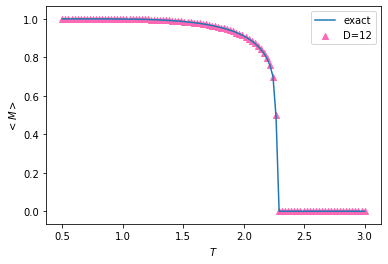

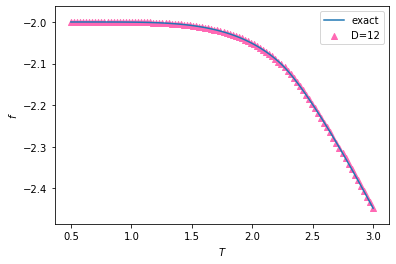

In [9]:
D = 12
d = 2
J=1

print('Bond dimension: D =', D)
A = createMPS(D, d)
Al, Ar, Ac, C = mixedCanonical(A)
# optimization parameters
tol = 1e-5

T_array = np.linspace(0.5,3,100)
magnetizations = []
magnetizations_exact = []
frees = []
frees_exact = []

for T in T_array:
    beta = 1/T
    O = isingO(beta, J)
    t0 = time()
    delta = 1e-4
    flag = 1
    i = 0
    while flag:
        lam, Fl = leftFixedPointMPO(Al, O, delta)
        _ , Fr = rightFixedPointMPO(Ar, O, delta)
        Fl /= overlapFixedPointsMPO(Fl, Fr, C)
        lam = np.real(lam)[0]
        AcPrime, cPrime = calcNewCenterMPO(Ac, C, Fl, Fr, O, lam, delta)
        AlPrime, ArPrime, AcPrime, cPrime = minAcC(AcPrime, cPrime)
        delta = np.linalg.norm(OAc(Ac, Fl, Fr, O, lam) - ncon((Al, OC(C, Fl, Fr)), ([-1, -2, 1], [1, -3])))
        Al, Ar, Ac, C = AlPrime, ArPrime, AcPrime, cPrime
        i += 1
        if delta < tol:
            flag = 0

    print('##############')
    print('T={}'.format(T))
    print('Time for VUMPS optimization:', time()-t0, 's')
    print('Iterations needed:', i)
    freeEnergy = freeEnergyDensity(beta, lam)
    freeEnergyExact = isingExact(beta, J)[1]
    print('Computed free energy:', freeEnergy)
    print('Exact free energy:', freeEnergyExact)
    print('##############')

    magnetizations.append(abs(isingMagnetization(beta, J, Ac, Fl, Fr)/isingZ(beta, J, Ac, Fl, Fr)))
    magnetizations_exact.append(isingExact(beta, J)[0])

    frees.append(freeEnergyDensity(beta, lam))
    frees_exact.append(isingExact(beta, J)[1])

plt.figure()
plt.grid
plt.xlabel(r'$T$')
plt.ylabel(r'$<M>$')
plt.scatter([T for T in T_array], magnetizations, label = 'D={}'.format(D), c="hotpink", marker="^")
plt.plot([T for T in T_array], magnetizations_exact, label = 'exact')
plt.legend()
plt.figure()
plt.grid
plt.xlabel(r'$T$')
plt.ylabel(r'$f$')
plt.scatter([T for T in T_array], frees, label = 'D={}'.format(D), c="hotpink", marker="^")
plt.plot([T for T in T_array], frees_exact, label = 'exact')
plt.legend()